# 📊 Validation Statistique d'un Estimateur Monte Carlo pour Option Call Européenne

Ce notebook a pour objectif de valider rigoureusement l'estimateur de prix de Monte Carlo (MC) pour une option Call Européenne sous le modèle de Black-Scholes-Merton (GBM), en testant la simulation, la convergence théorique, et la cohérence statistique de l'Intervalle de Confiance (IC).

---

## ⚙️ 0. Initialisation et Définition des Fonctions

Cette section définit toutes les fonctions nécessaires à l'analyse : le simulateur de prix, le pricer MC, la formule analytique de référence, et les fonctions de visualisation.

In [53]:
%matplotlib inline

In [60]:
# Ajoutez les lignes de rechargement pour être sûr de prendre en compte toutes modifications de fichiers source
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:


# ------------------------------------------------------------------
# Imports des bibliothèques standard 
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm 

# Importations nécessaires pour corriger le chemin d'accès
import sys
import os

# ------------------------------------------------------------------
# CORRECTION DU CHEMIN D'ACCÈS POUR LES IMPORTS LOCAUX
# Le Notebook étant dans 'notebooks/', nous ajoutons le répertoire parent (MBG_MONTECARLO)
# au chemin de recherche Python(PYTHONPATH) pour trouver le dossier 'src'.
# ------------------------------------------------------------------

# Obtient le chemin absolu du répertoire de travail actuel
# (Ex: /chemin/vers/MBG_MONTECARLO/notebooks)
current_dir = os.getcwd() 

# Remonte au répertoire parent (Ex: /chemin/vers/MBG_MONTECARLO)
parent_dir = os.path.dirname(current_dir)

# Ajoute le répertoire parent à sys.path. 
# Maintenant, Python sait que 'src' est un sous-dossier valide.
sys.path.append(parent_dir)

# ------------------------------------------------------------------
# IMPORTATIONS DES FONCTIONS SOURCES
# Les imports devraient maintenant fonctionner
# ------------------------------------------------------------------
# Note : J'ai adapté l'import car vous avez montré une structure plate dans src/.
# J'ai aussi ajouté 'Test_couverture_IC' et 'Analyse_convergence_erreur'
# comme modules basés sur votre capture.
from src.simuler_modele import simuler_ST, plot_histogram

#from src.estimateur_montecarlo import prix_montecarlo_call, vrai_prix_call 

from src.analyse_convergence_erreur import plot_convergence_RMSE

from src.test_couverture_IC import plot_couverture_IC, monte_carlo_couverture_IC

# ------------------------------------------------------------------
# Définition des paramètres fondamentaux de l'option
# ------------------------------------------------------------------
S0 = 100.0   # Prix initial du sous-jacent
K = 100.0    # Prix d'exercice (Strike)
r = 0.05     # Taux sans risque
sigma = 0.2  # Volatilité
T = 1.0      # Temps jusqu'à l'échéance (en années)

#---------------------------------------------------------------
#Parametre pour la génération de nombre aléatoire
#---------------------------------------------------------------

seed = 21



<unknown>:113: SyntaxWarning: invalid escape sequence '\h'
<unknown>:113: SyntaxWarning: invalid escape sequence '\h'


---

## 1. 🔍 Validation du Modèle Stochastique (GBM)

Cette étape vérifie que la fonction `simuler_ST` produit des prix $S_T$ qui suivent la distribution théorique Log-Normale du modèle GBM.

--- 1. Validation de la Log-Normalité pour N=1000000 ---


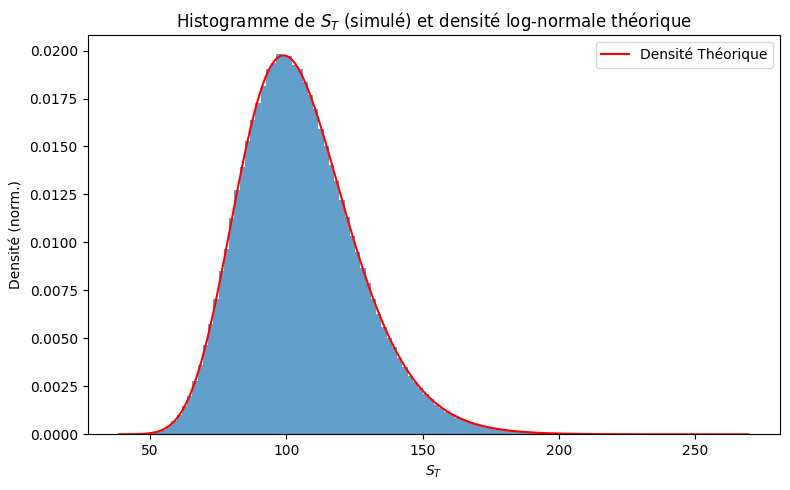

In [49]:
# ==============================================================================
# 1. VALIDATION DU MODÈLE : DISTRIBUTION LOG-NORMALE DE S_T
# ==============================================================================

N_histogramme = 10**6 

print(f"--- 1. Validation de la Log-Normalité pour N={N_histogramme} ---")

# Simulation des prix finaux S_T
ST_simule = simuler_ST(S0, r, sigma, T, N_histogramme, seed=seed)

# Affichage et comparaison avec la densité théorique
plot_histogram(ST_simule, S0, r, sigma, T)

# Interprétation : L'alignement de l'histogramme avec la courbe rouge valide 
# l'implémentation de la dynamique du sous-jacent.

---

## 2. 📈 Validation de la Convergence ($O(N^{-1/2})$)

Cette étape prouve que la méthode Monte Carlo est non seulement convergente (Loi des Grands Nombres), mais qu'elle atteint la vitesse de convergence théorique prédite par le Théorème Central Limite (TCL), soit $O(N^{-1/2})$.

--- 2. Validation de la Convergence O(N^{-1/2}) ---
Testé sur une gamme de N : 100 à 1000000


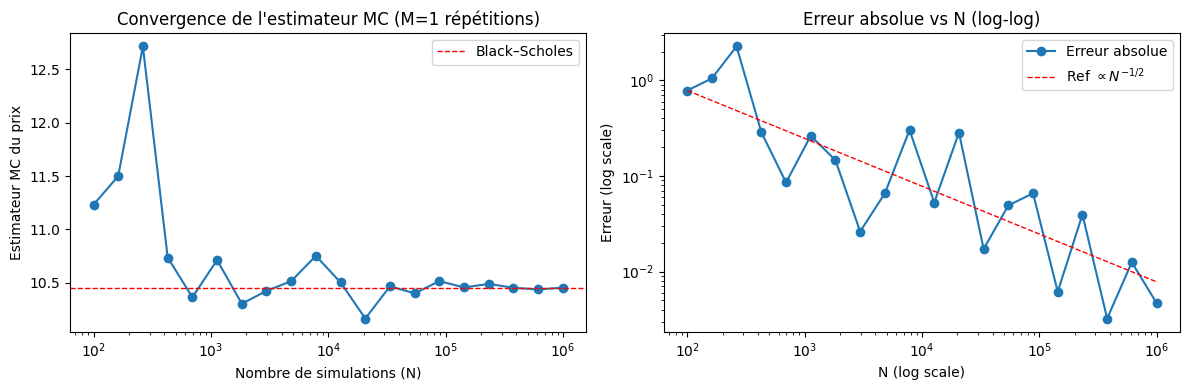

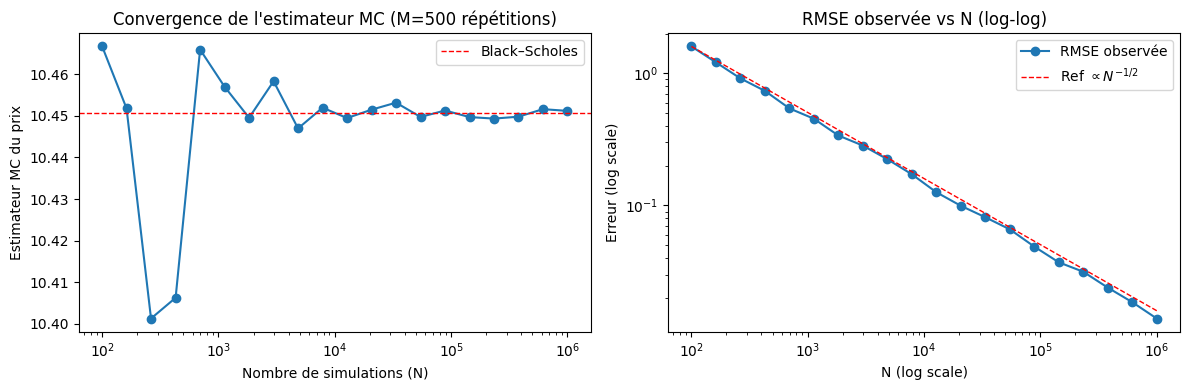

In [ ]:
# ==============================================================================
# 2. VALIDATION DE LA CONVERGENCE : LGN et O(N^{-1/2})
# ==============================================================================

# Gamme de N testés (de 10^2 à 10^6)
Ns_convergence = np.logspace(2, 6, 20, dtype=int) 

M_lissage = 500

print("--- 2. Validation de la Convergence O(N^{-1/2}) ---")
print(f"Testé sur une gamme de N : {Ns_convergence[0]} à {Ns_convergence[-1]}")

# Exécution et tracé de la convergence pour une repetition
plot_convergence_RMSE(S0, K, r, sigma, T, Ns_convergence,M_repetitions= 1, seed=seed)

# Exécution et tracé de la convergence pour M_lissage(=500) repetitions

plot_convergence_RMSE(S0, K, r, sigma, T, Ns_convergence, M_repetitions= M_lissage, seed = seed)

# Interprétation : Sur le graphique log-log (à droite), l'erreur observée doit 
# suivre la droite de référence de pente -0.5, confirmant le respect du TCL.

---

## 3. ✅ Cohérence Statistique (Test de Couverture IC)

Cette étape est la validation statistique de la mesure d'incertitude. On vérifie si l'Intervalle de Confiance à 95 % est fiable en s'assurant qu'il couvre le prix analytique ($C_{\text{BS}}$) environ 95 % du temps.

<unknown>:113: SyntaxWarning: invalid escape sequence '\h'
<unknown>:113: SyntaxWarning: invalid escape sequence '\h'


--- 3. Validation de l'Intervalle de Confiance (IC 95%) ---
N (Simulations par estimation) : 100000
M (Répétitions du test) : 500

Prix analytique (C_BS) : 10.450584
Taux de Couverture Empirique observé : 94.40%


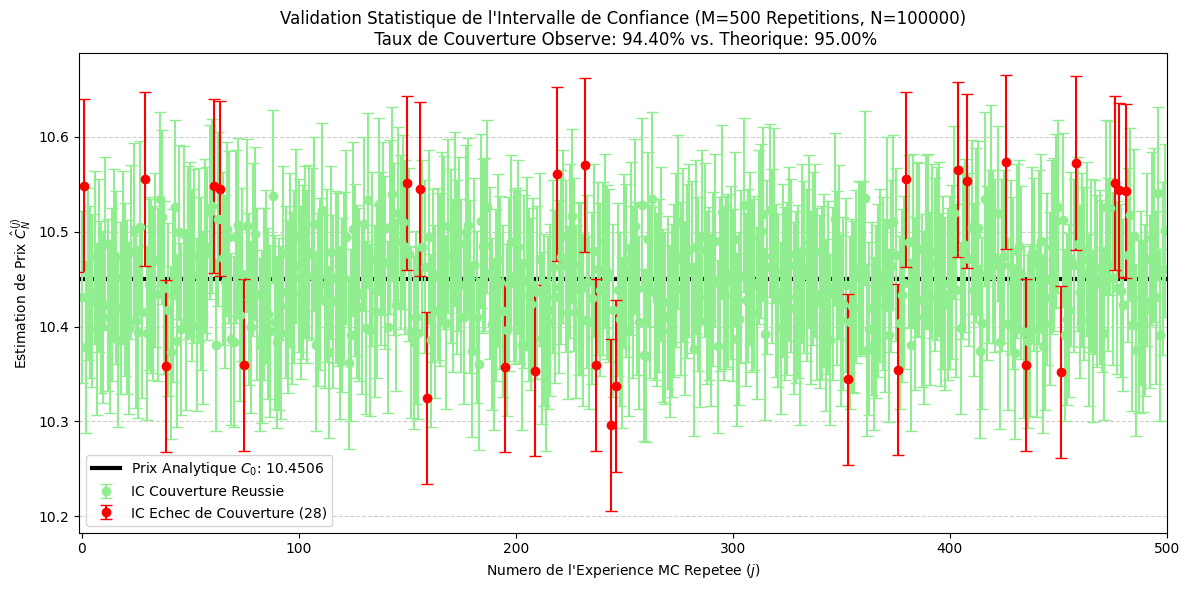

In [70]:
# ==============================================================================
# 3. VALIDATION STATISTIQUE : TEST DU TAUX DE COUVERTURE DE L'IC
# ==============================================================================

# Paramètres du Test Statistique
N_IC = 10**5     # N: Simulations par estimation
M_IC = 500      # M: Répétitions du test 
alpha_level = 0.05 # IC à 95%

print(f"--- 3. Validation de l'Intervalle de Confiance (IC {int((1-alpha_level)*100)}%) ---")
print(f"N (Simulations par estimation) : {N_IC}")
print(f"M (Répétitions du test) : {M_IC}")

# 1. Exécution du test de couverture et récupération des données
taux_obs, C_BS, estimateurs, demi_largeur_ICs = monte_carlo_couverture_IC(
    S0, K, r, sigma, T, N_IC, M_IC,seed=seed)

# 2. Affichage des résultats numériques
print(f"\nPrix analytique (C_BS) : {C_BS:.6f}")
print(f"Taux de Couverture Empirique observé : {taux_obs:.2%}")

# 3. Tracé du graphique de validation (IC Coverage Plot)
plot_couverture_IC (taux_obs, C_BS, N_IC ,estimateurs,demi_largeur_ICs)